In [73]:
from utils.analyse_runs import *
from utils.analyse_training import *

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype=torch.float64

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# DF of all runs sorted by best_avg_loss

In [74]:
df = load_runs_table("./runs")
df.head()

,run_id,best_avg_loss,best_epoch,epoch,lr_drops_used,kernel_mode,kernel_spec,esn_h,esn_m,esn_out_dim,...,target_T,target_p,target_q,target_phi,target_theta,target_omega,target_alpha,target_beta,target_noise_spec,run_path
0,esn_vs_ARMA_RBFKernel_20260224_093047_cpu,-0.002045,254,504,3,static,RBFKernel(sigma=26.735400176591458),500,20,1,...,200.0,2.0,0.0,"[0.699999988079071, -0.20000000298023224]",[],NaN,NaN,NaN,"{'kind': 'normal', 'params': {}}",runs/esn_vs_ARMA_RBFKernel_20260224_093047_cpu
1,esn_vs_ARMA_RBFKernel_20260224_095230_cpu,-0.001942,247,497,3,static,RBFKernel(sigma=27.59954485390008),500,20,1,...,200.0,2.0,0.0,"[0.699999988079071, -0.20000000298023224]",[],NaN,NaN,NaN,"{'kind': 'normal', 'params': {}}",runs/esn_vs_ARMA_RBFKernel_20260224_095230_cpu
2,esn_vs_GARCH11_RBFKernel_20260224_112046_cpu,-0.001688,368,618,3,static,RBFKernel(sigma=27.297456301582134),500,20,1,...,200.0,NaN,NaN,None,None,0.1,0.2,0.7,"{'kind': 'normal', 'params': {}}",runs/esn_vs_GARCH11_RBFKernel_20260224_112046_cpu
3,esn_vs_ARMA_RBFKernel_20260224_093243_cpu,-0.001300,125,375,3,static,RBFKernel(sigma=27.41221356384992),500,20,1,...,200.0,2.0,0.0,"[0.699999988079071, -0.20000000298023224]",[],NaN,NaN,NaN,"{'kind': 'normal', 'params': {}}",runs/esn_vs_ARMA_RBFKernel_20260224_093243_cpu
4,esn_vs_DataLoader_SigKernel_20260223_194954_cpu,0.017043,29,279,3,sequential,"SigKernel(dyadic_order=0, static_kernel_name=R...",500,20,1,...,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None,runs/esn_vs_DataLoader_SigKernel_20260223_1949...


# Pick one row and show loss progression and plot some samples

In [75]:
row = 2

## loss progrssion for this particular run

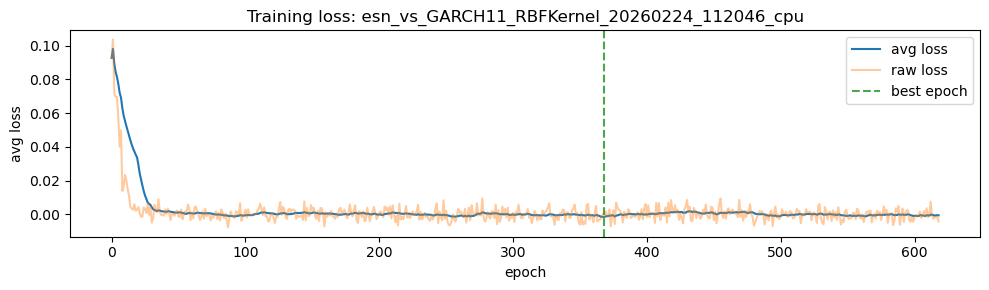

Kernel spec: RBFKernel(sigma=27.297456301582134)
Best average loss: -0.0017 at epoch 368
Final average loss: -0.0007
Final loss: -0.0043


In [76]:
results = df.iloc[row]
losses = plot_loss_from_run(results, None, overlay_raw=True, log_scale=False, overlay_lr = True, mark_best_and_drops=True)
print(f"Kernel spec: {results['kernel_spec']}")
print(f"Best average loss: {results['best_avg_loss']:.4f} at epoch {results['best_epoch']}")
print(f"Final average loss: {losses['avg_losses'][-1]:.4f}")
print(f"Final loss: {losses['losses'][-1]:.4f}")

## load and plot samples for this particular run

### ESN

In [77]:
esn_cols = [col for col in df.columns if "esn_" in col]
df.iloc[row][esn_cols]

esn_h                                                            500
esn_m                                                             20
esn_out_dim                                                        1
esn_activation                                                  tanh
esn_xi_scale                                                     1.0
esn_eta_scale                                                   0.05
esn_target_rho                                                  0.99
esn_xi_ma_theta    [0.30000001192092896, 0.25, 0.2000000029802322...
esn_quad_gain                                                    0.1
Name: 2, dtype: object

In [78]:
esn = load_esn_from_df(df, row=row, which="best", map_location=device, dtype=torch.float64)
# with torch.no_grad():
#     Z = esn(T=200, N=50)
# print(Z.shape)

### Generator

In [79]:
target_cols = [col for col in df.columns if "target_" in col and "esn_" not in col]   
df.iloc[row][target_cols]

target_name                                   GARCH11
target_T                                        200.0
target_p                                          NaN
target_q                                          NaN
target_phi                                       None
target_theta                                     None
target_omega                                      0.1
target_alpha                                      0.2
target_beta                                       0.7
target_noise_spec    {'kind': 'normal', 'params': {}}
Name: 2, dtype: object

In [80]:
generator, noise = load_target_and_noise_from_df(df, row=row)
# with torch.no_grad():
#     Z_target = generator.generate(N=50, T=1000, noise=noise)
# print(Z_target.shape)

# ACF analysis

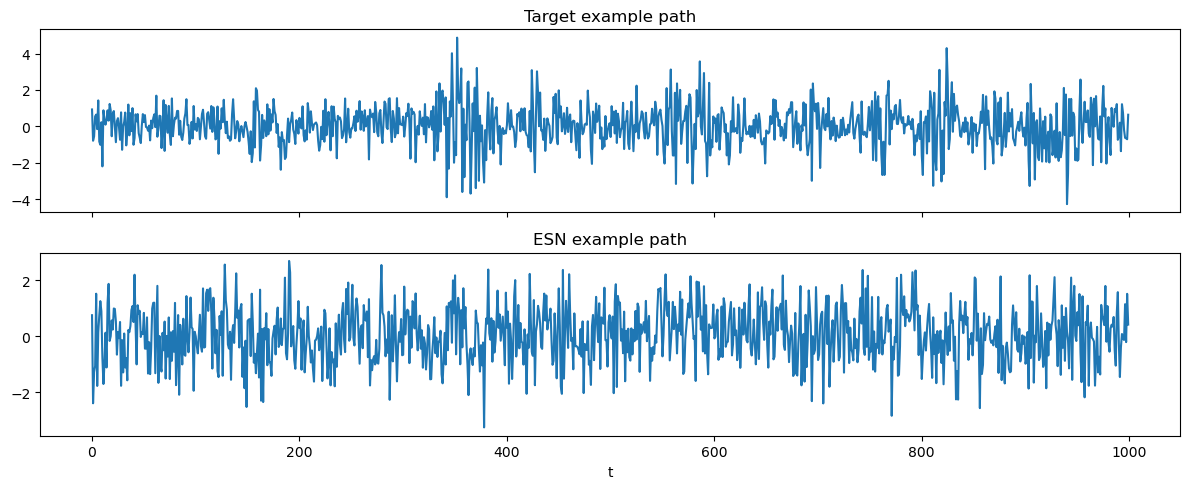

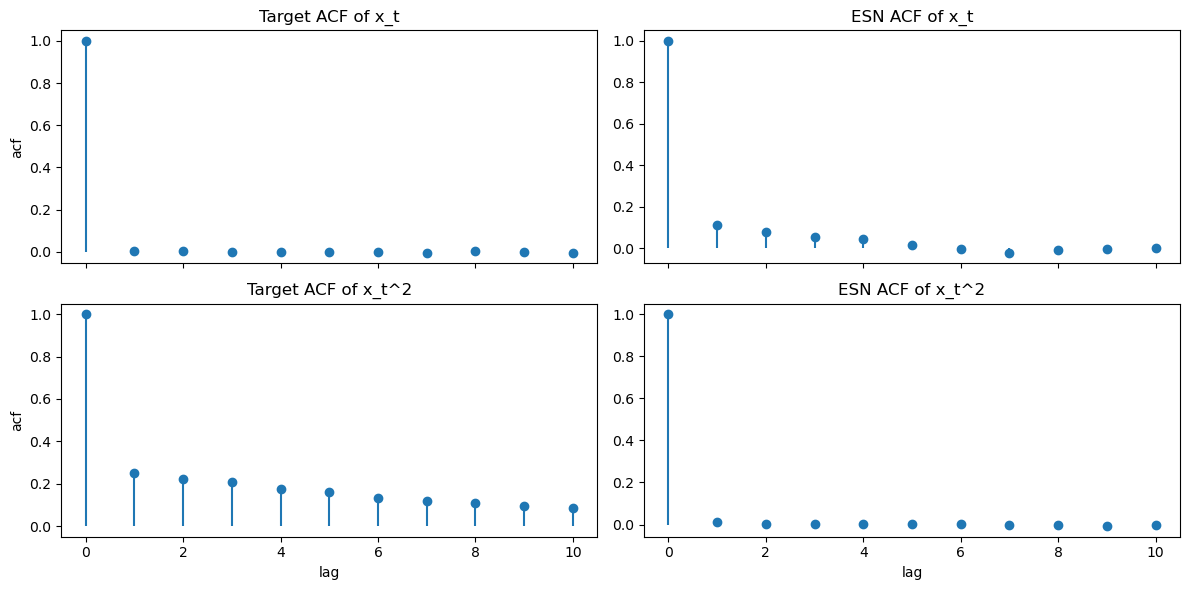

In [82]:
out = acf_compare(esn=esn, generator=generator, N=100, T=1000, lag=10, noise=noise)